In [1]:
%run setup.ipynb
from scipy.stats import dirichlet
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import traceback
import logging

logger = logging.getLogger('ag1000g-phase2')
logger.setLevel(logging.DEBUG)

# create console handler with a higher log level
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)

# create formatter and add it to the handlers
formatter = logging.Formatter(
    '%(asctime)s - %(name)s - %(levelname)s - %(message)s')
ch.setFormatter(formatter)
# add the handlers to logger
logger.addHandler(ch)

In [3]:
#generate counts
Fpos = 2422652
Spos = 2422651

callset = phase2_ar1.callset_pass_biallelic['2L']
g = allel.GenotypeChunkedArray(callset['calldata']['genotype'])
pos = allel.SortedIndex(callset['variants']['POS'])
df_meta = pd.read_csv('../phase2.AR1/samples/samples.meta.txt', sep='\t')

Fb = pos.values == Fpos
Sb = pos.values == Spos

def het_pop(pop):
    FSb = Fb + Sb
    popbool = np.array(df_meta.population == pop)
    popg = g.compress(popbool, axis=1)
    popgr = popg.compress(FSb, axis=0)
    a = np.asarray(popgr.to_n_alt())
    return a

In [4]:
gagam = het_pop('GAgam')
cagam = het_pop('CMgam')
np.save('../data/gabon_n_alt.npy', gagam)
np.save('../data/cameroon_n_alt.npy', cagam)

In [6]:
def run_fs_het_analysis(path, ns=1_000_000):

    ac = np.load(path).T
    logger.info(f"Loaded {path}")
    
    # assuming col1 is F, col2 is S
    assert ac.sum(axis=1).max() == 2

    tot_alleles = ac.shape[0] * 2
    
    n_samples = ac.shape[0]
    logger.info(f"{n_samples} samples found")

    wt_alleles = tot_alleles - ac.sum()
    wt_alleles

    f_alleles = ac[:, 0].sum()
    s_alleles = ac[:, 1].sum()

    alpha = [1 + wt_alleles, 1 + f_alleles, 1 + s_alleles]
    
    logger.info(f"Dirichlet alpha set to {alpha}")
    
    diric = dirichlet(alpha)
    wt, f, s = diric.mean()
    logger.info(
        f"Mean of dirichlet- wt: {wt:.2f}, f:{f:.2f}, s:{s:.2f}")
    
    # this is what we observed
    is_het = (ac[:, 0] == ac[:, 1]) & (ac.sum(axis=1) == 2)
    tot_fs_hets = is_het.sum()
    
    logger.info(
        f"In the AC data we observe {tot_fs_hets} F-S hets")

    logger.info(f"Beginning monte carlo analysis, n={ns}")
    
    # draw 1m dirichlet observations of allele frequency
    v = np.random.dirichlet(alpha, size=ns)

    # for each of the 1m, sample n_samples, 
    # and count how many "F/S" hets we observe
    o = np.zeros(ns, dtype="int")
    for i in range(v.shape[0]):
        x = np.random.multinomial(2, v[i], size=n_samples)
        o[i] = np.sum((x[:, 1] == 1) & (x[:, 2] == 1))

    fig, ax = plt.subplots(figsize=(4, 4))
    bins = np.arange(0, max(o.max(), tot_fs_hets) + 5, 1)
    count, bins, patches = ax.hist(
        o, bins=bins, density=True)

    ymin, ymax = ax.get_ylim()
    ax.vlines([tot_fs_hets], ymin=ymin, ymax=ymax)
    sns.despine(ax=ax)
    
    grt = tot_fs_hets >= o
    les = tot_fs_hets <= o
    
    logger.info(
        "{:.3f} of simulated values are greater than or equal to the observed".format(
            1 - np.mean(grt)))
    
    logger.info(
        "{:.3f} of simulated values are less than or equal to the observed".format(
            1 - np.mean(les)))

2019-11-21 11:38:15,961 - ag1000g-phase2 - INFO - Loaded ../data/gabon_n_alt.npy
2019-11-21 11:38:15,963 - ag1000g-phase2 - INFO - 69 samples found
2019-11-21 11:38:15,964 - ag1000g-phase2 - INFO - Dirichlet alpha set to [1, 94, 46]
2019-11-21 11:38:15,965 - ag1000g-phase2 - INFO - Mean of dirichlet- wt: 0.01, f:0.67, s:0.33
2019-11-21 11:38:15,966 - ag1000g-phase2 - INFO - In the AC data we observe 41 F-S hets
2019-11-21 11:38:15,967 - ag1000g-phase2 - INFO - Beginning monte carlo analysis, n=1000000
2019-11-21 11:38:54,452 - ag1000g-phase2 - INFO - 0.005 of simulated values are greater than or equal to the observed
2019-11-21 11:38:54,454 - ag1000g-phase2 - INFO - 0.991 of simulated values are less than or equal to the observed


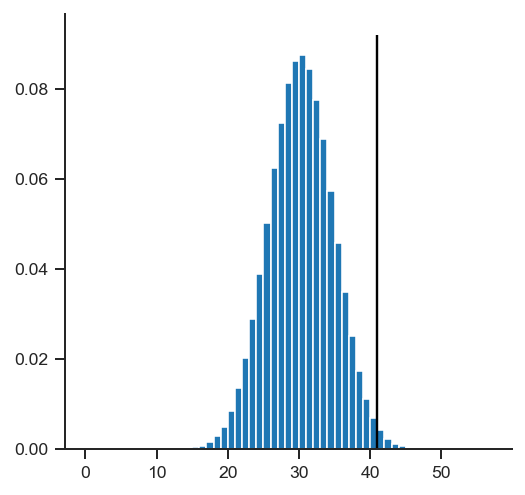

In [7]:
run_fs_het_analysis("../data/gabon_n_alt.npy")

2019-11-21 11:38:54,686 - ag1000g-phase2 - INFO - Loaded ../data/cameroon_n_alt.npy
2019-11-21 11:38:54,688 - ag1000g-phase2 - INFO - 297 samples found
2019-11-21 11:38:54,689 - ag1000g-phase2 - INFO - Dirichlet alpha set to [190, 94, 313]
2019-11-21 11:38:54,690 - ag1000g-phase2 - INFO - Mean of dirichlet- wt: 0.32, f:0.16, s:0.52
2019-11-21 11:38:54,691 - ag1000g-phase2 - INFO - In the AC data we observe 50 F-S hets
2019-11-21 11:38:54,691 - ag1000g-phase2 - INFO - Beginning monte carlo analysis, n=1000000
2019-11-21 11:40:10,898 - ag1000g-phase2 - INFO - 0.410 of simulated values are greater than or equal to the observed
2019-11-21 11:40:10,899 - ag1000g-phase2 - INFO - 0.539 of simulated values are less than or equal to the observed


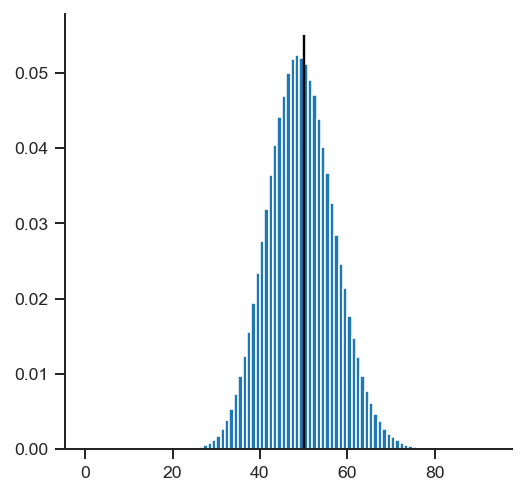

In [8]:
run_fs_het_analysis("../data/cameroon_n_alt.npy")